# IMPORTAÇÃO DAS BIBLIOTECAS

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import powerlaw, kstest
import numpy as np
from datetime import datetime

In [2]:
# Configurações para exibir todas as linhas e colunas 
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 

# Configuração para exibir todo o conteúdo das células 
pd.set_option('display.max_colwidth', None)

# BIBLIOTECAS AUXILIARES

In [33]:
# Step 1: Load and clean the data
def load_data(file_path):
    linkedin_data = (
        pd.read_csv(file_path, sep=';')
        .dropna()
    )
    # Convert "Connected On" to datetime
    linkedin_data["Connected On"] = pd.to_datetime(
        linkedin_data["Connected On"], dayfirst=True
    )
    # # Calculate "Days Connected"
    # linkedin_data["Days Connected"] = (
    #     datetime.now() - linkedin_data["Connected On"]
    # ).dt.days
    # Filter companies with at least 3 occurrences
    linkedin_data = linkedin_data.groupby("Company").filter(lambda x: len(x) >= 3)
    return linkedin_data

In [15]:
# Step 2: Create the graph
def create_graph(data):
    G = nx.Graph()
    owner_node = "Owner"
    G.add_node(owner_node, role="Owner")

    for _, row in data.iterrows():
        connection_name = f"{row['First Name']} {row['Last Name']}"
        G.add_node(connection_name, company=row['Company'], position=row['Position'], days_connected=row['Days Connected'])
        G.add_edge(owner_node, connection_name, weight=row['Days Connected'])  # Use "Days Connected" as edge weight

    return G

In [5]:
# Step 3: Add company-based edges
def add_company_edges(G, data):
    company_groups = data.groupby("Company")
    # Precompute full names once to avoid repetitive computation
    group_full_names = {company: group["First Name"].str.cat(group["Last Name"], sep=" ").tolist() for company, group in company_groups}

    for company, employees in group_full_names.items():
        for i in range(len(employees)):
            for j in range(i + 1, len(employees)):
                weight = min(
                    data[(data["First Name"] + " " + data["Last Name"]) == employees[i]]['Days Connected'].iloc[0],
                    data[(data["First Name"] + " " + data["Last Name"]) == employees[j]]['Days Connected'].iloc[0]
                )
                G.add_edge(employees[i], employees[j], weight=weight, relationship="Colleagues")

In [6]:
# Step 4: Analyze the graph
def analyze_graph(G):
    clustering_coefficient = nx.average_clustering(G, weight='weight')
    average_path_length = nx.average_shortest_path_length(G, weight='weight') if nx.is_connected(G) else None
    return clustering_coefficient, average_path_length

In [7]:
# Step 5: Identify key influencers
def compute_centrality_measures(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
    eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')

    centrality_df = pd.DataFrame({
        'Node': list(G.nodes),
        'Degree Centrality': degree_centrality.values(),
        'Betweenness Centrality': betweenness_centrality.values(),
        'Eigenvector Centrality': eigenvector_centrality.values(),
        'Days Connected': [G.nodes[node].get('days_connected', None) for node in G.nodes()]
    })

    top_influencers = centrality_df.sort_values(by='Degree Centrality', ascending=False).head(10)
    return top_influencers, degree_centrality

In [8]:
# Step 6: Visualize degree distribution
def plot_degree_distribution(G):
    degrees = [degree for _, degree in G.degree()]
    plt.figure(figsize=(8, 6))
    plt.hist(degrees, bins=range(1, max(degrees) + 2), align='left', edgecolor='black')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Check for scale-free network
    plt.figure(figsize=(8, 6))
    plt.loglog(sorted(degrees, reverse=True), marker='o', linestyle='None')
    plt.title("Log-Log Plot of Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Fit power-law distribution (ensure dataset size is sufficient)
    if len(degrees) < 30:
        print("Dataset too small to reliably fit a power-law distribution.")
        return

    degrees = np.array(degrees)
    alpha, loc, scale = powerlaw.fit(degrees)

    # Plot power-law fit
    plt.figure(figsize=(8, 6))
    plt.hist(degrees, bins=30, density=True, alpha=0.7, label='Degree Distribution')
    x = np.linspace(min(degrees), max(degrees), 100)
    plt.plot(x, powerlaw.pdf(x, alpha, loc, scale), 'r-', label=f'Power Law Fit (α={alpha:.2f})')
    plt.xlabel("Degree")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Degree Distribution and Power Law Fit")
    plt.show()

    # Perform Kolmogorov-Smirnov test
    D, p_value = kstest(degrees, 'powerlaw', args=(alpha, loc, scale))
    print(f"Kolmogorov-Smirnov Test: D = {D}, p-value = {p_value}")

In [19]:
# Step 7: Visualize the graph interactively with key hubs highlighted
def visualize_graph_interactive(G, degree_centrality, title="Graph Visualization"):
    pos = nx.spring_layout(G, weight='weight')

    # Extracting edge and node information for Plotly
    edge_x = []
    edge_y = []
    edge_weights = []
    filtered_edges = [edge for edge in G.edges(data=True) if edge[2].get('weight', 1) > 1]
    for edge in filtered_edges:
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        edge_weights.append(edge[2].get('weight', 1))

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Assigning node colors and sizes based on company
    company_colors = {company: f"hsl({i * 360 / len(set(nx.get_node_attributes(G, 'company').values()))}, 70%, 50%)" 
                      for i, company in enumerate(set(nx.get_node_attributes(G, 'company').values()))}

    node_x = []
    node_y = []
    node_text = []
    node_color = []
    node_size = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f"{node}<br>Company: {G.nodes[node].get('company', 'N/A')}<br>Degree Centrality: {degree_centrality[node]:.4f}<br>Days Connected: {G.nodes[node].get('days_connected', 'N/A')}")
        node_color.append(company_colors.get(G.nodes[node].get('company', 'N/A'), '#cccccc'))
        node_size.append(10)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=False,
            color=node_color,
            size=node_size,
            line_width=2))

    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    title=title,
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0,l=0,r=0,t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

    fig.show()


In [10]:
# Step 8: Explain metrics
def explain_metrics():
    explanations = {
        "Degree Centrality": "Indicates the number of direct connections a node has. Higher values suggest greater immediate influence.",
        "Betweenness Centrality": "Measures the extent to which a node lies on the shortest paths between other nodes. Higher values indicate a bridging role.",
        "Eigenvector Centrality": "Considers both the quantity and quality of connections. Nodes connected to influential nodes score higher.",
        "Average Path Length": "Indicates the average number of steps along the shortest paths for all pairs of nodes.",
        "Degree Distribution": "Describes how connections are distributed among nodes in the network. Scale-free networks typically exhibit a power-law degree distribution."
    }
    for metric, explanation in explanations.items():
        print(f"{metric}: {explanation}\n")


In [11]:
# Step 10: Main function to orchestrate the workflow
def main(file_path):
    data = load_data(file_path)
    G = create_graph(data)
    add_company_edges(G, data)

    clustering_coefficient, average_path_length = analyze_graph(G)
    print(f"Clustering Coefficient: {clustering_coefficient}")
    if average_path_length is not None:
        print(f"Average Path Length: {average_path_length}")
    else:
        print("Graph is not connected; cannot compute average path length.")

    top_influencers, degree_centrality = compute_centrality_measures(G)
    print("Top Influencers:")
    print(top_influencers)

    explain_metrics()
    plot_degree_distribution(G)
    visualize_graph_interactive(G, degree_centrality, title="Final Interactive Graph with Key Hubs Highlighted")


# EXECUTA O PROCESSO

Clustering Coefficient: 0.25336590335210657
Average Path Length: 1421.334513738606
Top Influencers:
                         Node  Degree Centrality  Betweenness Centrality  \
0                       Owner           1.000000                0.881221   
384        Vlademir Eleuterio           0.305128                0.000000   
364           Tiemi Kobayashi           0.305128                0.000000   
367           Uemerson Santos           0.305128                0.000000   
362              Tiago Simões           0.305128                0.000000   
360      Thiago Jose da Silva           0.305128                0.000000   
353               Thais Gomes           0.305128                0.000000   
363              Tiago Vianez           0.305128                0.000000   
23   Angelica Gozzani Tozetti           0.305128                0.000000   
22              Angela Achcar           0.305128                0.000000   

     Eigenvector Centrality  Days Connected  
0                

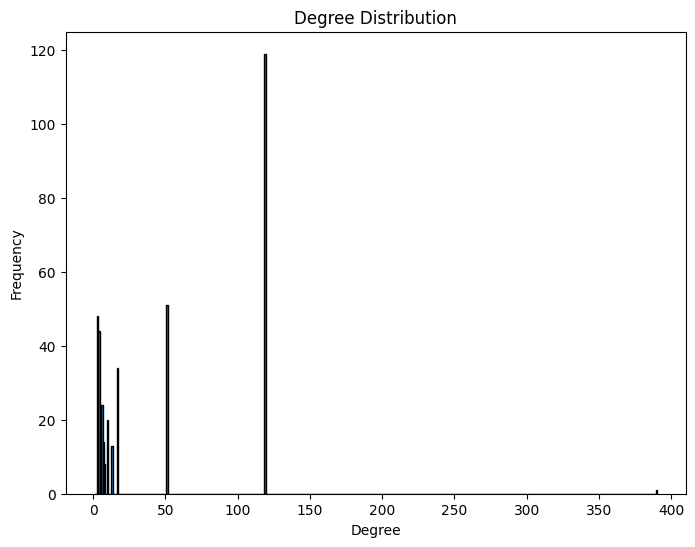

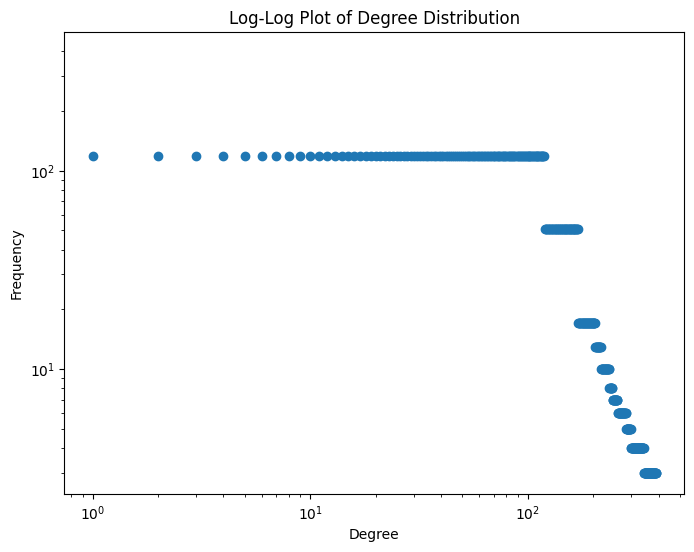

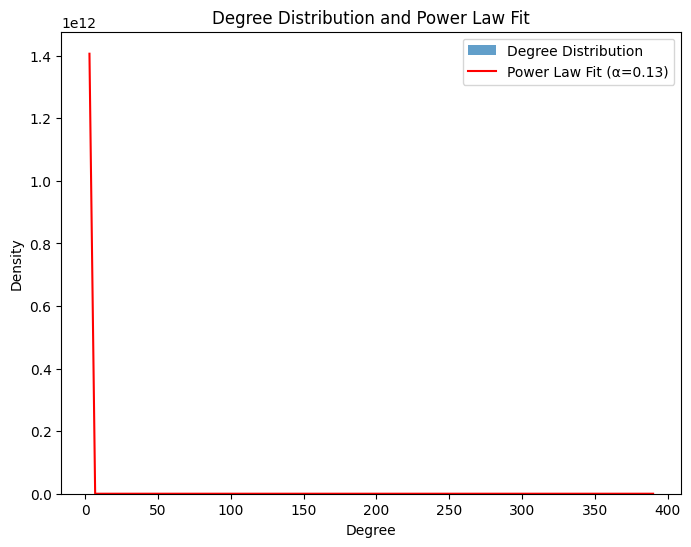

Kolmogorov-Smirnov Test: D = 0.3407492222767341, p-value = 5.053441456939803e-41


In [34]:
main("..\small_world_linkedin\data\linkedin_v2.csv")

# TESTES MANUAIS

In [56]:
df = (
    pd.read_csv("..\small_world_linkedin\data\linkedin.csv", skiprows=3, usecols=['First Name', 'Last Name', 'URL'], nrows=10)
    .dropna(subset=['URL'])
)

In [57]:
df.head(20)

,First Name,Last Name,URL
0,Samuel,Borges,https://www.linkedin.com/in/samuelborges87
1,Danilo,Ramos,https://www.linkedin.com/in/danilo-ramos-325b3439
2,Flávio De,Araújo Silva 🏳️‍🌈,https://www.linkedin.com/in/flaviodearaujosilva
3,Gabriel,Moreira,https://www.linkedin.com/in/ga-brielmoreira
4,Gustavo,Pacheco Lopes,https://www.linkedin.com/in/gustavo-pacheco-lopes
5,Rafael,M. Carvalho,https://www.linkedin.com/in/rafaelmcarvalho-analistadedados
6,Gabriel,Damasceno Rodrigues,https://www.linkedin.com/in/gabrieldamascenorodrigues
7,Laisson,Bruno,https://www.linkedin.com/in/laissonbruno
8,John,Garcia,https://www.linkedin.com/in/john-garcia-804b7b
9,Gabriel,Alves,https://www.linkedin.com/in/gabriel-alves-319145258


In [58]:
df.shape

(10, 3)

In [28]:
df["Connected On"] = pd.to_datetime(
    df["Connected On"], dayfirst=True
)

In [17]:
df["Days Connected"] = (datetime.today() - df["Connected On"]).dt.days

In [30]:
df.groupby(['Company'])['Company'].count().to_frame('QTD').reset_index().sort_values(by='QTD', ascending=False)

,Company,QTD
510,Serasa Experian,119
145,Crawford & Company,51
317,Itaú Unibanco,17
48,Autônomo,17
85,Bradesco,13
204,Experian,10
583,USP - Universidade de São Paulo,10
265,Grupo Boticário,8
504,Sedgwick,7
464,RTS International Loss Adjusters,7
